In [72]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras

In [73]:
DATA_PATH = "data.json"  
actual= []
predicted=[]

In [74]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [75]:

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(10, 10))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="Train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="Train error")
    axs[1].plot(history.history["val_loss"], label="Test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    fig.tight_layout(pad=1.5)
    axs[0].grid()
    axs[1].grid()

    plt.show()


In [76]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test



In [77]:

def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


In [78]:


def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    actual.append(y)
    predicted.append(predicted_index)
    print("Target: {}, Predicted label: {}".format(y, predicted_index))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 64, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

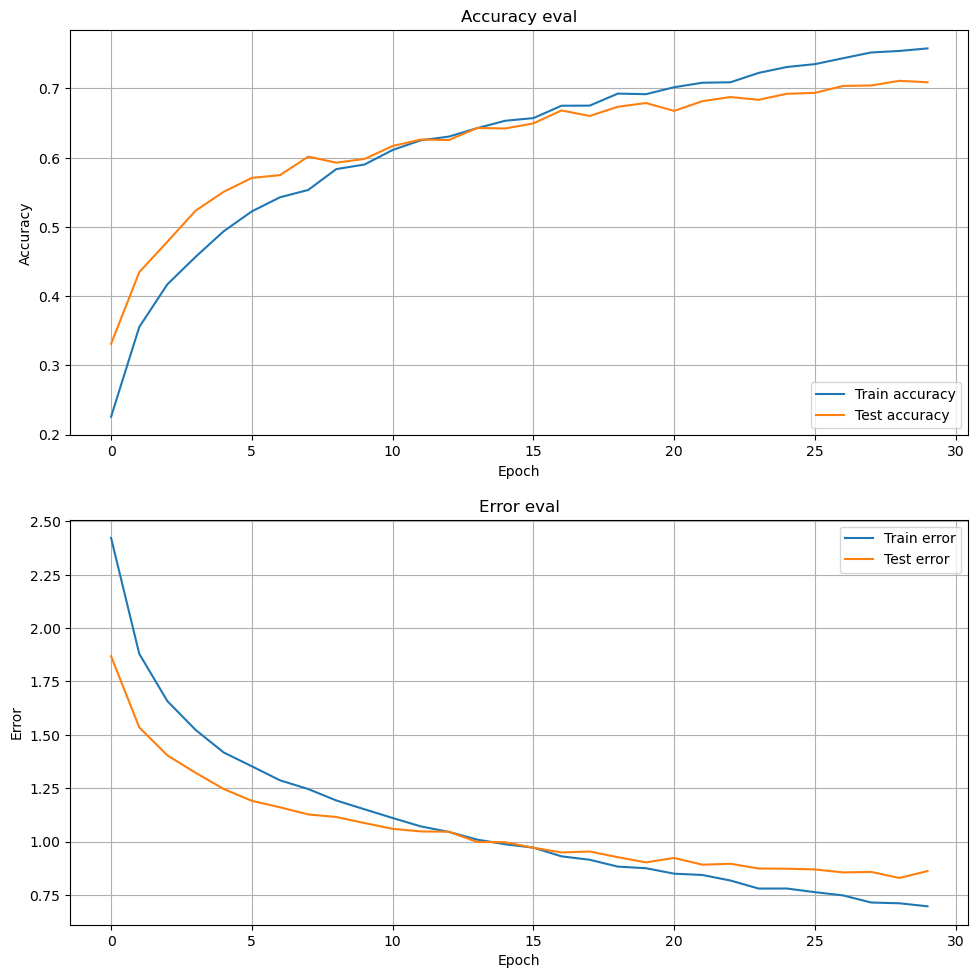

79/79 - 1s - loss: 0.8351 - accuracy: 0.7157 - 872ms/epoch - 11ms/step

Test accuracy: 0.7156587839126587
1/1 [==============================] - 0s 263ms/step
Target: 5, Predicted label: [5]


In [79]:


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)



In [80]:
count= X_test.shape[0]
count

2497

In [81]:

for i in range(count):
    X_to_predict = X_test[i]
    y_to_predict = y_test[i]
    predict(model, X_to_predict, y_to_predict)


1/1 [==============================] - 0s 42ms/step
Target: 7, Predicted label: [7]
1/1 [==============================] - 0s 45ms/step
Target: 9, Predicted label: [9]
1/1 [==============================] - 0s 43ms/step
Target: 1, Predicted label: [1]
1/1 [==============================] - 0s 45ms/step
Target: 0, Predicted label: [0]
1/1 [==============================] - 0s 41ms/step
Target: 5, Predicted label: [5]
1/1 [==============================] - 0s 41ms/step
Target: 3, Predicted label: [3]
1/1 [==============================] - 0s 41ms/step
Target: 1, Predicted label: [1]
1/1 [==============================] - 0s 42ms/step
Target: 5, Predicted label: [2]
1/1 [==============================] - 0s 43ms/step
Target: 3, Predicted label: [3]
1/1 [==============================] - 0s 44ms/step
Target: 4, Predicted label: [4]
1/1 [==============================] - 0s 45ms/step
Target: 8, Predicted label: [7]
1/1 [==============================] - 0s 44ms/step
Target: 7, Predicted lab

In [83]:
def Extract(predicted):
    return [item[0] for item in predicted]
predicted2= Extract(predicted)

In [93]:
import pandas as pd

# Create a dataframe from the lists
df = pd.DataFrame({'actual': actual, 'predicted': predicted2})

df.to_json('actual_prediction.json', orient='records')